In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)

if args.separate_params:
    params_decoder = list(target.parameters())
    params_inference = list(encoder.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer_inference = torch.optim.Adam(params=params_inference, lr=args.learning_rate_inference)
    optimizer = torch.optim.Adam(params=params_decoder, lr=args.learning_rate)
else:
    params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
    
optimizer_vanilla = torch.optim.Adam(params=list(encoder.parameters()) + list(target.parameters()), lr= args.learning_rate_vanilla)

In [6]:
if args.vanilla_vae_epoches > 0:
    batch_size = args.train_batch_size
    args.train_batch_size = 100 # just for Vanilla VAE training
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

  0%|          | 0/1000 [00:00<?, ?it/s]

Current epoch: 1 	 Current ELBO: -168.75425720214844
Saved samples to ./pics/mnist_epoch_0_K_5_N_1_amortize_False.png


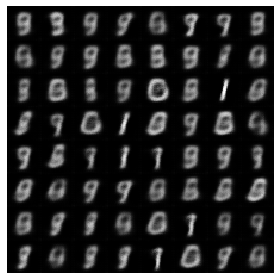

  0%|          | 1/1000 [00:07<2:08:03,  7.69s/it]

Current epoch: 2 	 Current ELBO: -146.8052215576172
Saved samples to ./pics/mnist_epoch_1_K_5_N_1_amortize_False.png


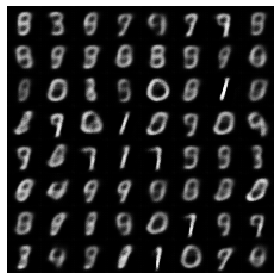

  0%|          | 2/1000 [00:14<2:02:36,  7.37s/it]

Current epoch: 3 	 Current ELBO: -132.80516052246094
Saved samples to ./pics/mnist_epoch_2_K_5_N_1_amortize_False.png


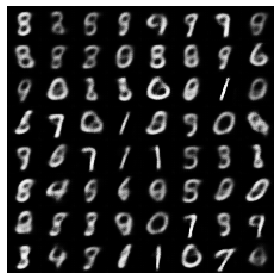

  0%|          | 3/1000 [00:20<1:58:44,  7.15s/it]

Current epoch: 4 	 Current ELBO: -129.32281494140625
Saved samples to ./pics/mnist_epoch_3_K_5_N_1_amortize_False.png


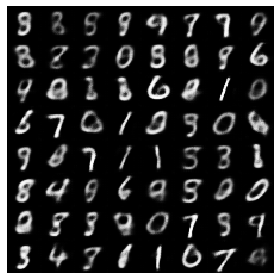

  0%|          | 4/1000 [00:27<1:56:00,  6.99s/it]

Current epoch: 5 	 Current ELBO: -118.78218078613281
Saved samples to ./pics/mnist_epoch_4_K_5_N_1_amortize_False.png


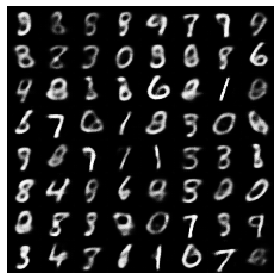

  0%|          | 5/1000 [00:34<1:54:01,  6.88s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4460000211838633 and for +1: 0.554000026313588
On batch number 1/118 and on k = 2 we have for  0: 0.5200000246986747 and for +1: 0.4800000227987766
On batch number 1/118 and on k = 3 we have for  0: 0.5240000248886645 and for +1: 0.4760000226087868
On batch number 1/118 and on k = 4 we have for  0: 0.5320000252686441 and for +1: 0.4680000222288072
On batch number 1/118 and on k = 5 we have for  0: 0.5500000261235982 and for +1: 0.4500000213738531
On batch number 101/118 and on k = 1 we have for  0: 0.21800001035444438 and for +1: 0.7820000371430069
On batch number 101/118 and on k = 2 we have for  0: 0.5840000277385116 and for +1: 0.41600001975893974
On batch number 101/118 and on k = 3 we have for  0: 0.4760000226087868 and for +1: 0.5240000248886645
On batch number 101/118 and on k = 4 we have for  0: 0.4540000215638429 and for +1: 0.5460000259336084
On batch number 101/118 and on k = 5 we have for  0: 0.43600002070888877 and for +

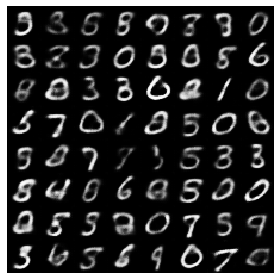

  1%|          | 6/1000 [02:40<11:45:10, 42.57s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.21000000997446477 and for +1: 0.7900000375229865
On batch number 1/118 and on k = 2 we have for  0: 0.61600002925843 and for +1: 0.3840000182390213
On batch number 1/118 and on k = 3 we have for  0: 0.472000022418797 and for +1: 0.5280000250786543
On batch number 1/118 and on k = 4 we have for  0: 0.4560000216588378 and for +1: 0.5440000258386135
On batch number 1/118 and on k = 5 we have for  0: 0.4480000212788582 and for +1: 0.5520000262185931
On batch number 101/118 and on k = 1 we have for  0: 0.4560000216588378 and for +1: 0.5440000258386135
On batch number 101/118 and on k = 2 we have for  0: 0.5320000252686441 and for +1: 0.4680000222288072
On batch number 101/118 and on k = 3 we have for  0: 0.5220000247936696 and for +1: 0.4780000227037817
On batch number 101/118 and on k = 4 we have for  0: 0.43600002070888877 and for +1: 0.5640000267885625
On batch number 101/118 and on k = 5 we have for  0: 0.4740000225137919 and for +1: 

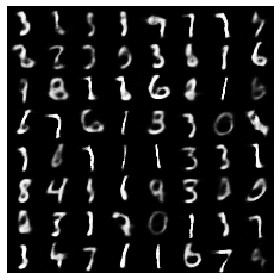

  1%|          | 7/1000 [04:46<18:39:00, 67.61s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.41200001956894994 and for +1: 0.5880000279285014
On batch number 1/118 and on k = 2 we have for  0: 0.5300000251736492 and for +1: 0.4700000223238021
On batch number 1/118 and on k = 3 we have for  0: 0.49200002336874604 and for +1: 0.5080000241287053
On batch number 1/118 and on k = 4 we have for  0: 0.43400002061389387 and for +1: 0.5660000268835574
On batch number 1/118 and on k = 5 we have for  0: 0.4420000209938735 and for +1: 0.5580000265035778
On batch number 101/118 and on k = 1 we have for  0: 0.3060000145342201 and for +1: 0.6940000329632312
On batch number 101/118 and on k = 2 we have for  0: 0.6460000306833535 and for +1: 0.35400001681409776
On batch number 101/118 and on k = 3 we have for  0: 0.5100000242237002 and for +1: 0.49000002327375114
On batch number 101/118 and on k = 4 we have for  0: 0.4540000215638429 and for +1: 0.5460000259336084
On batch number 101/118 and on k = 5 we have for  0: 0.49000002327375114 and f

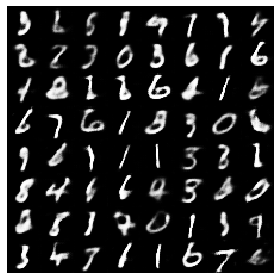

  1%|          | 8/1000 [06:52<23:30:53, 85.34s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.42200002004392445 and for +1: 0.5780000274535269
On batch number 1/118 and on k = 2 we have for  0: 0.5220000247936696 and for +1: 0.4780000227037817
On batch number 1/118 and on k = 3 we have for  0: 0.6300000299233943 and for +1: 0.370000017574057
On batch number 1/118 and on k = 4 we have for  0: 0.6020000285934657 and for +1: 0.3980000189039856
On batch number 1/118 and on k = 5 we have for  0: 0.6600000313483179 and for +1: 0.34000001614913344
On batch number 101/118 and on k = 1 we have for  0: 0.3100000147242099 and for +1: 0.6900000327732414
On batch number 101/118 and on k = 2 we have for  0: 0.596000028308481 and for +1: 0.4040000191889703
On batch number 101/118 and on k = 3 we have for  0: 0.5580000265035778 and for +1: 0.4420000209938735
On batch number 101/118 and on k = 4 we have for  0: 0.4680000222288072 and for +1: 0.5320000252686441
On batch number 101/118 and on k = 5 we have for  0: 0.48800002317875624 and for +1

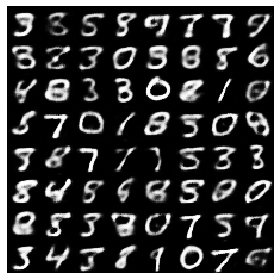

  1%|          | 9/1000 [08:59<26:54:20, 97.74s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.34000001614913344 and for +1: 0.6600000313483179
On batch number 1/118 and on k = 2 we have for  0: 0.6400000303983688 and for +1: 0.36000001709908247
On batch number 1/118 and on k = 3 we have for  0: 0.5040000239387155 and for +1: 0.49600002355873585
On batch number 1/118 and on k = 4 we have for  0: 0.4740000225137919 and for +1: 0.5260000249836594
On batch number 1/118 and on k = 5 we have for  0: 0.4620000219438225 and for +1: 0.5380000255536288
On batch number 101/118 and on k = 1 we have for  0: 0.6720000319182873 and for +1: 0.32800001557916403
On batch number 101/118 and on k = 2 we have for  0: 0.6940000329632312 and for +1: 0.3060000145342201
On batch number 101/118 and on k = 3 we have for  0: 0.7100000337231904 and for +1: 0.2900000137742609
On batch number 101/118 and on k = 4 we have for  0: 0.6000000284984708 and for +1: 0.4000000189989805
On batch number 101/118 and on k = 5 we have for  0: 0.5240000248886645 and for

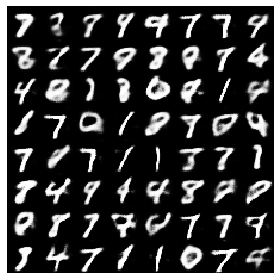

  1%|          | 10/1000 [11:06<29:16:01, 106.43s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5780000274535269 and for +1: 0.42200002004392445
On batch number 1/118 and on k = 2 we have for  0: 0.7340000348631293 and for +1: 0.26600001263432205
On batch number 1/118 and on k = 3 we have for  0: 0.8520000404678285 and for +1: 0.1480000070296228
On batch number 1/118 and on k = 4 we have for  0: 0.7260000344831496 and for +1: 0.27400001301430166
On batch number 1/118 and on k = 5 we have for  0: 0.48800002317875624 and for +1: 0.5120000243186951
On batch number 101/118 and on k = 1 we have for  0: 0.2340000111144036 and for +1: 0.7660000363830477
On batch number 101/118 and on k = 2 we have for  0: 0.6400000303983688 and for +1: 0.36000001709908247
On batch number 101/118 and on k = 3 we have for  0: 0.6080000288784504 and for +1: 0.3920000186190009
On batch number 101/118 and on k = 4 we have for  0: 0.5360000254586339 and for +1: 0.4640000220388174
On batch number 101/118 and on k = 5 we have for  0: 0.4500000213738531 and fo

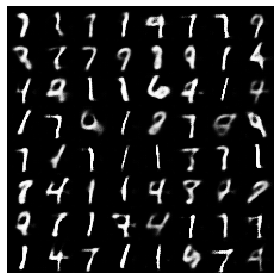

  1%|          | 11/1000 [13:12<30:54:42, 112.52s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.26000001234933734 and for +1: 0.740000035148114
On batch number 1/118 and on k = 2 we have for  0: 0.6300000299233943 and for +1: 0.370000017574057
On batch number 1/118 and on k = 3 we have for  0: 0.5480000260286033 and for +1: 0.452000021468848
On batch number 1/118 and on k = 4 we have for  0: 0.4620000219438225 and for +1: 0.5380000255536288
On batch number 1/118 and on k = 5 we have for  0: 0.43400002061389387 and for +1: 0.5660000268835574
On batch number 101/118 and on k = 1 we have for  0: 0.3780000179540366 and for +1: 0.6220000295434147
On batch number 101/118 and on k = 2 we have for  0: 0.574000027263537 and for +1: 0.42600002023391426
On batch number 101/118 and on k = 3 we have for  0: 0.5480000260286033 and for +1: 0.452000021468848
On batch number 101/118 and on k = 4 we have for  0: 0.5080000241287053 and for +1: 0.49200002336874604
On batch number 101/118 and on k = 5 we have for  0: 0.370000017574057 and for +1: 0

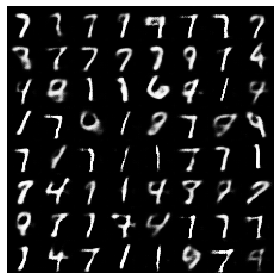

  1%|          | 12/1000 [15:19<32:02:50, 116.77s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.2940000139642507 and for +1: 0.7060000335332006
On batch number 1/118 and on k = 2 we have for  0: 0.6300000299233943 and for +1: 0.370000017574057
On batch number 1/118 and on k = 3 we have for  0: 0.48600002308376133 and for +1: 0.51400002441369
On batch number 1/118 and on k = 4 we have for  0: 0.4700000223238021 and for +1: 0.5300000251736492
On batch number 1/118 and on k = 5 we have for  0: 0.4040000191889703 and for +1: 0.596000028308481
On batch number 101/118 and on k = 1 we have for  0: 0.3100000147242099 and for +1: 0.6900000327732414
On batch number 101/118 and on k = 2 we have for  0: 0.576000027358532 and for +1: 0.42400002013891935
On batch number 101/118 and on k = 3 we have for  0: 0.48800002317875624 and for +1: 0.5120000243186951
On batch number 101/118 and on k = 4 we have for  0: 0.48600002308376133 and for +1: 0.51400002441369
On batch number 101/118 and on k = 5 we have for  0: 0.41600001975893974 and for +1: 0

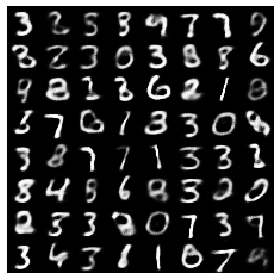

  1%|▏         | 13/1000 [17:26<32:49:51, 119.75s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.27600001310929656 and for +1: 0.7240000343881547
On batch number 1/118 and on k = 2 we have for  0: 0.636000030208379 and for +1: 0.3640000172890723
On batch number 1/118 and on k = 3 we have for  0: 0.5280000250786543 and for +1: 0.472000022418797
On batch number 1/118 and on k = 4 we have for  0: 0.43000002042390406 and for +1: 0.5700000270735472
On batch number 1/118 and on k = 5 we have for  0: 0.3860000183340162 and for +1: 0.6140000291634351
On batch number 101/118 and on k = 1 we have for  0: 0.390000018524006 and for +1: 0.6100000289734453
On batch number 101/118 and on k = 2 we have for  0: 0.49800002365373075 and for +1: 0.5020000238437206
On batch number 101/118 and on k = 3 we have for  0: 0.42800002032890916 and for +1: 0.5720000271685421
On batch number 101/118 and on k = 4 we have for  0: 0.3960000188089907 and for +1: 0.6040000286884606
On batch number 101/118 and on k = 5 we have for  0: 0.34600001643411815 and for +

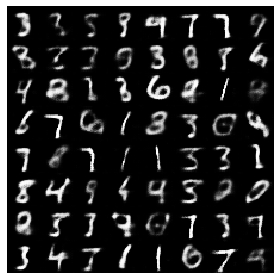

  1%|▏         | 14/1000 [20:05<36:03:36, 131.66s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.42000001994892955 and for +1: 0.5800000275485218
On batch number 1/118 and on k = 2 we have for  0: 0.5080000241287053 and for +1: 0.49200002336874604
On batch number 1/118 and on k = 3 we have for  0: 0.4460000211838633 and for +1: 0.554000026313588
On batch number 1/118 and on k = 4 we have for  0: 0.42200002004392445 and for +1: 0.5780000274535269
On batch number 1/118 and on k = 5 we have for  0: 0.370000017574057 and for +1: 0.6300000299233943
On batch number 101/118 and on k = 1 we have for  0: 0.5380000255536288 and for +1: 0.4620000219438225
On batch number 101/118 and on k = 2 we have for  0: 0.5420000257436186 and for +1: 0.4580000217538327
On batch number 101/118 and on k = 3 we have for  0: 0.5420000257436186 and for +1: 0.4580000217538327
On batch number 101/118 and on k = 4 we have for  0: 0.5060000240337104 and for +1: 0.49400002346374094
On batch number 101/118 and on k = 5 we have for  0: 0.2860000135842711 and for +

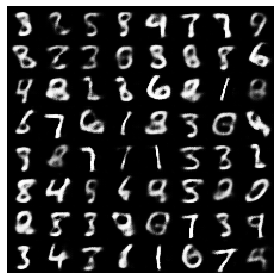

  2%|▏         | 15/1000 [24:24<46:27:17, 169.78s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.26800001272931695 and for +1: 0.7320000347681344
On batch number 1/118 and on k = 2 we have for  0: 0.6020000285934657 and for +1: 0.3980000189039856
On batch number 1/118 and on k = 3 we have for  0: 0.5560000264085829 and for +1: 0.4440000210888684
On batch number 1/118 and on k = 4 we have for  0: 0.42400002013891935 and for +1: 0.576000027358532
On batch number 1/118 and on k = 5 we have for  0: 0.4020000190939754 and for +1: 0.5980000284034759
On batch number 101/118 and on k = 1 we have for  0: 0.35400001681409776 and for +1: 0.6460000306833535
On batch number 101/118 and on k = 2 we have for  0: 0.5320000252686441 and for +1: 0.4680000222288072
On batch number 101/118 and on k = 3 we have for  0: 0.5100000242237002 and for +1: 0.49000002327375114
On batch number 101/118 and on k = 4 we have for  0: 0.42000001994892955 and for +1: 0.5800000275485218
On batch number 101/118 and on k = 5 we have for  0: 0.4700000223238021 and for

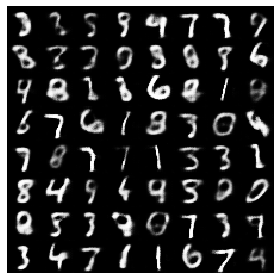

  2%|▏         | 16/1000 [27:40<48:34:35, 177.72s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.26000001234933734 and for +1: 0.740000035148114
On batch number 1/118 and on k = 2 we have for  0: 0.5940000282134861 and for +1: 0.40600001928396523
On batch number 1/118 and on k = 3 we have for  0: 0.5320000252686441 and for +1: 0.4680000222288072
On batch number 1/118 and on k = 4 we have for  0: 0.4420000209938735 and for +1: 0.5580000265035778
On batch number 1/118 and on k = 5 we have for  0: 0.3840000182390213 and for +1: 0.61600002925843
On batch number 101/118 and on k = 1 we have for  0: 0.33400001586414874 and for +1: 0.6660000316333026
On batch number 101/118 and on k = 2 we have for  0: 0.51400002441369 and for +1: 0.48600002308376133
On batch number 101/118 and on k = 3 we have for  0: 0.5880000279285014 and for +1: 0.41200001956894994
On batch number 101/118 and on k = 4 we have for  0: 0.49800002365373075 and for +1: 0.5020000238437206
On batch number 101/118 and on k = 5 we have for  0: 0.35800001700408757 and for +

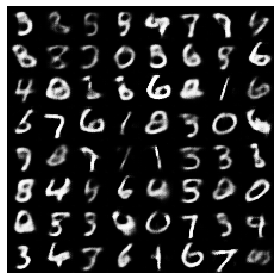

  2%|▏         | 17/1000 [30:00<45:27:15, 166.47s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.34800001652911305 and for +1: 0.6520000309683383
On batch number 1/118 and on k = 2 we have for  0: 0.5520000262185931 and for +1: 0.4480000212788582
On batch number 1/118 and on k = 3 we have for  0: 0.5800000275485218 and for +1: 0.42000001994892955
On batch number 1/118 and on k = 4 we have for  0: 0.4620000219438225 and for +1: 0.5380000255536288
On batch number 1/118 and on k = 5 we have for  0: 0.3940000187139958 and for +1: 0.6060000287834555
On batch number 101/118 and on k = 1 we have for  0: 0.1620000076945871 and for +1: 0.8380000398028642
On batch number 101/118 and on k = 2 we have for  0: 0.7000000332482159 and for +1: 0.3000000142492354
On batch number 101/118 and on k = 3 we have for  0: 0.6320000300183892 and for +1: 0.3680000174790621
On batch number 101/118 and on k = 4 we have for  0: 0.5080000241287053 and for +1: 0.49200002336874604
On batch number 101/118 and on k = 5 we have for  0: 0.41400001966394484 and for

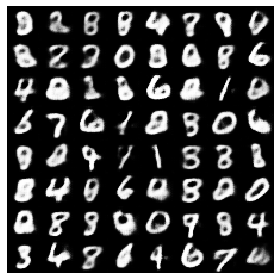

  2%|▏         | 18/1000 [32:17<42:59:07, 157.58s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.18600000883452594 and for +1: 0.8140000386629254
On batch number 1/118 and on k = 2 we have for  0: 0.7500000356230885 and for +1: 0.2500000118743628
On batch number 1/118 and on k = 3 we have for  0: 0.6320000300183892 and for +1: 0.3680000174790621
On batch number 1/118 and on k = 4 we have for  0: 0.5620000266935676 and for +1: 0.43800002080388367
On batch number 1/118 and on k = 5 we have for  0: 0.49400002346374094 and for +1: 0.5060000240337104


In [ ]:
print_info_ = 1
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo
  
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        target.decoder.train()
        plt.close()        

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        if ep < args.vanilla_vae_epoches:
            log_p = target.get_logdensity(z=z, x=batch_train)
            log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo_full = torch.mean(log_p - log_m)
            (-elbo_full).backward()
            optimizer_vanilla.step()
            optimizer_vanilla.zero_grad()
            if b_num == (args.train_batch_size - 1):
                args.train_batch_size = batch_size
                dataset = Dataset(args, device=args.device)
        else:
            p_old = args.std_normal.sample(z.shape)
            cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]

            sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
            sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
            p = p_old
            if args.learnable_reverse:
                all_directions = torch.tensor([], device=args.device)
            else:
                all_directions = None
            for k in range(args.K):
                # sample alpha - transition probabilities 
                if args.amortize:
    #                 pdb.set_trace()
                    z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                        p_old=p, k=cond_vectors[k], target_distr=target)
                else:
                    z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
                if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                    print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                            dataset.train.shape[0] // args['train_batch_size'],
                                                                               k + 1,
                                                        (directions==0.).to(float).mean(),
                                                                        (directions==1.).to(float).mean()))
                    if args.amortize:
                        print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                        print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
                if args.learnable_reverse:
                    all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
                # Accumulate alphas
                sum_log_alpha = sum_log_alpha + current_log_alphas
                sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian

            elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
        #     pdb.set_trace()
            (-grad_elbo).backward()
            if args.clip_norm:
                torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
                
            if args.separate_params: # if we separate params of inference part and generation part
                optimizer_inference.step() # we always perform step for inference part
                if (ep - args.vanilla_vae_epoches) % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                    optimizer.step()
                optimizer.zero_grad()
                optimizer_inference.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
            # Bias squared
    if ep % print_info_ == 0:
        target.decoder.eval()
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo_full.detach().mean().item())
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print('a')

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [ ]:
dataset = Dataset(args, device=args.device)

In [ ]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [ ]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)